In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import pypolar.fresnel as fresnel
from scipy.signal import find_peaks, peak_prominences
%config InlineBackend.figure_format = 'retina'

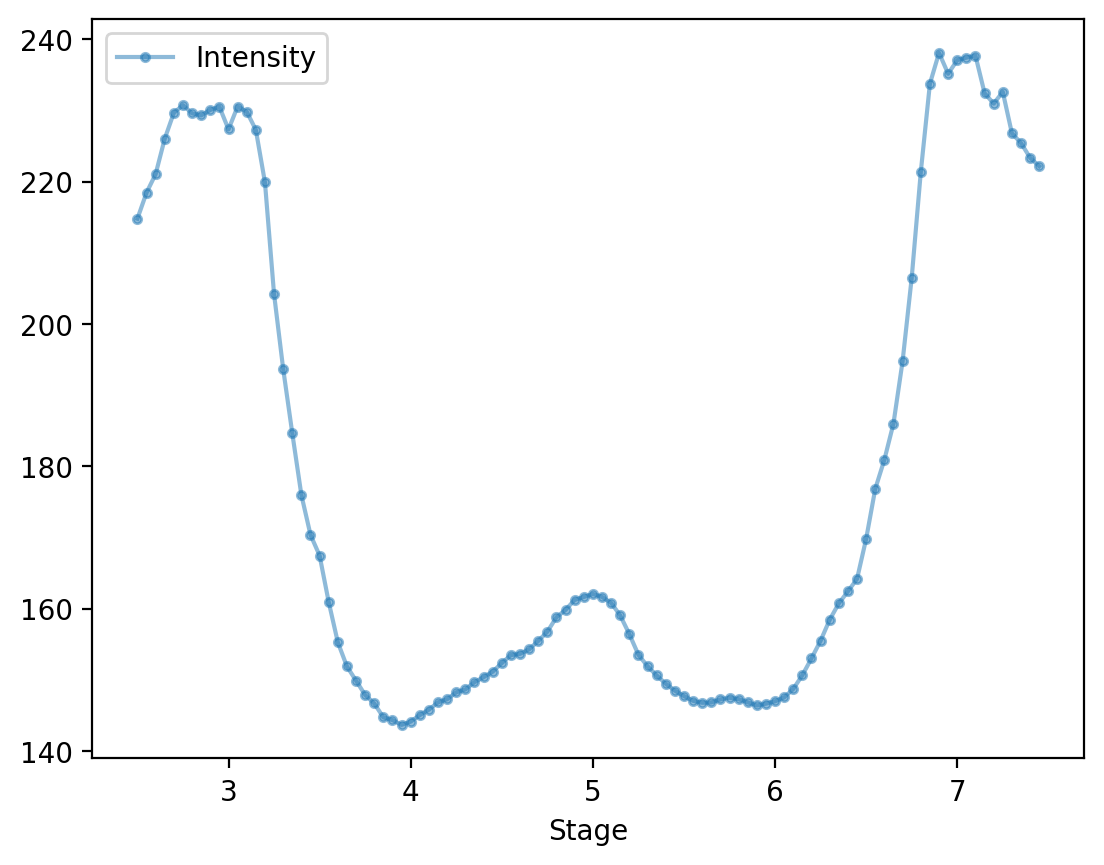

In [32]:
file_name = 'air-06-10-2025-p-intensities.csv'                                   # Input file name
df = pd.read_csv(file_name)
# Plot curve
df.plot(x="Stage", y="Intensity", alpha=0.5, style='.-')                                      # Plot
plt.show()

[15.95499022  3.2074364  15.66340509 15.92465753]
    Stage   Intensity
50    5.0  162.061644


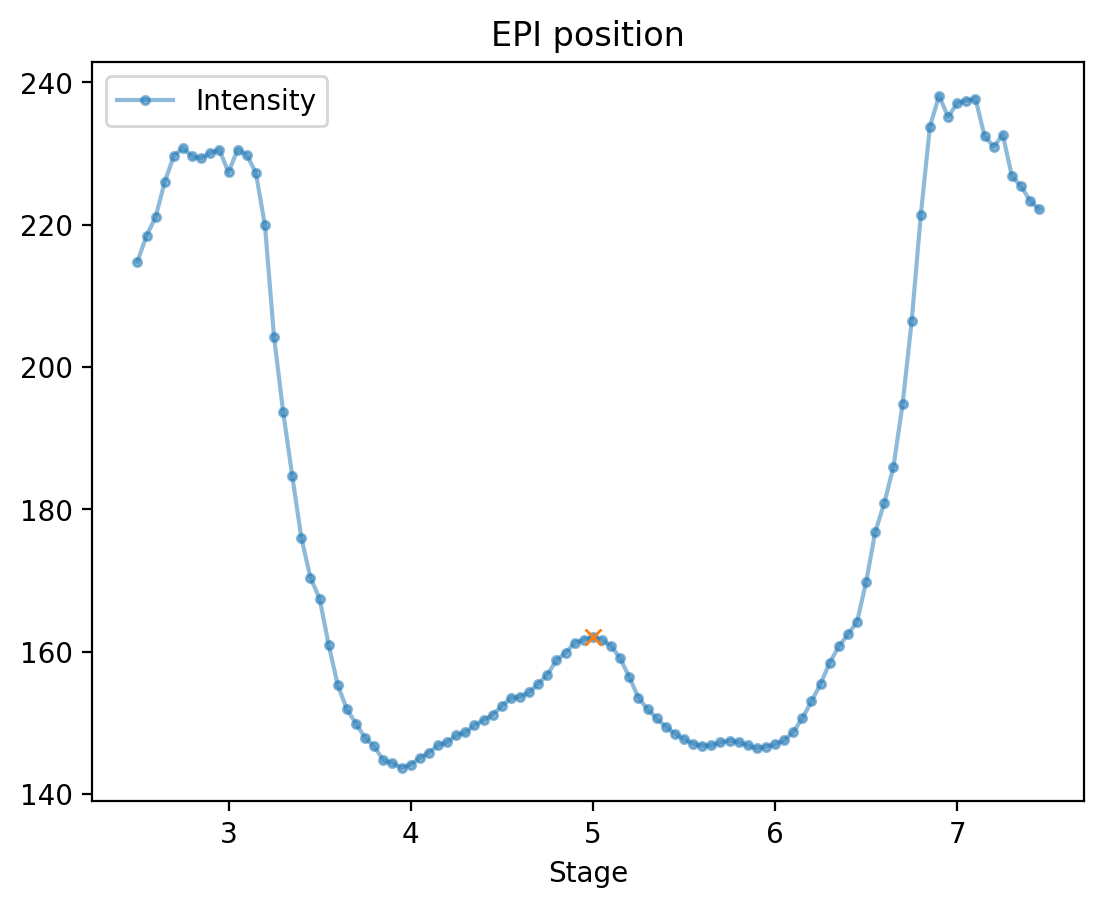

In [33]:
# Find EPI position
# 1. Clip the middle part :
x = df['Intensity'].to_numpy()
peaks_pos, _ = find_peaks(x, prominence=3)

# Check prominences if this doesn't work :
prominences = peak_prominences(x, peaks_pos)[0]
print(prominences)

epi_peak = peaks_pos[(df['Stage'][peaks_pos[:]] >= 4) & (df['Stage'][peaks_pos[:]] <= 6)]
# epi_peak = [df[df['Stage'] == 5.05].index[0]]
df.plot(x="Stage", y="Intensity", alpha=0.5, style='.-')
plt.plot(df['Stage'][epi_peak[:]], df['Intensity'][epi_peak[:]], "x")
plt.title('EPI position')
print(df.iloc[epi_peak[:]])

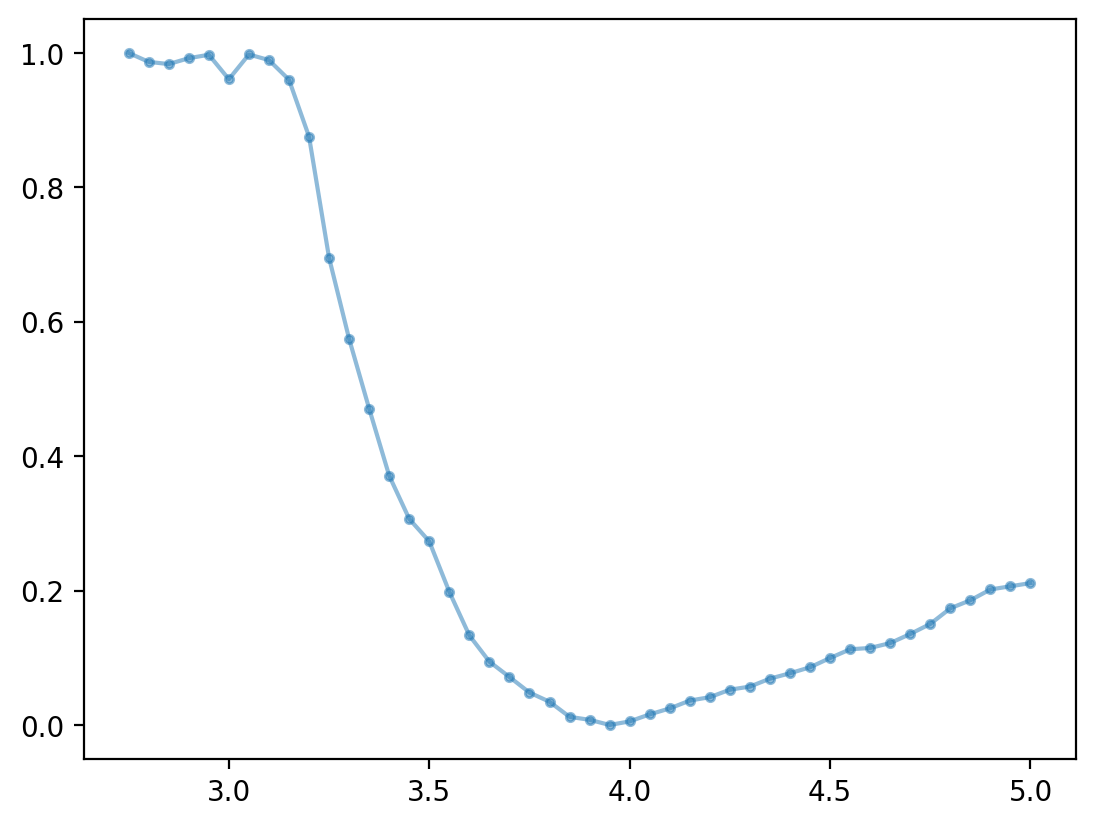

In [39]:
# Step 2 : Crop the original curve from one end to epi
df_crop = df.iloc[5:epi_peak[0]+1]
# Plot cropped curve
# df_crop.plot(x="Stage", y="Intensity", alpha=0.5, style='.-')                                       # Plot
# plt.show()

# Normalize array 
arr = df_crop['Intensity'].to_numpy()
normalized_arr = (arr - arr.min()) / (arr.max() - arr.min())
plt.plot(df_crop['Stage'],normalized_arr, '.-', alpha=0.5)

In [40]:
# Step 3 : Plot fresnel relation for irradiance.
n1 = 1.51   # refractive index of glass
n2 = 1.0    # refractive index of air

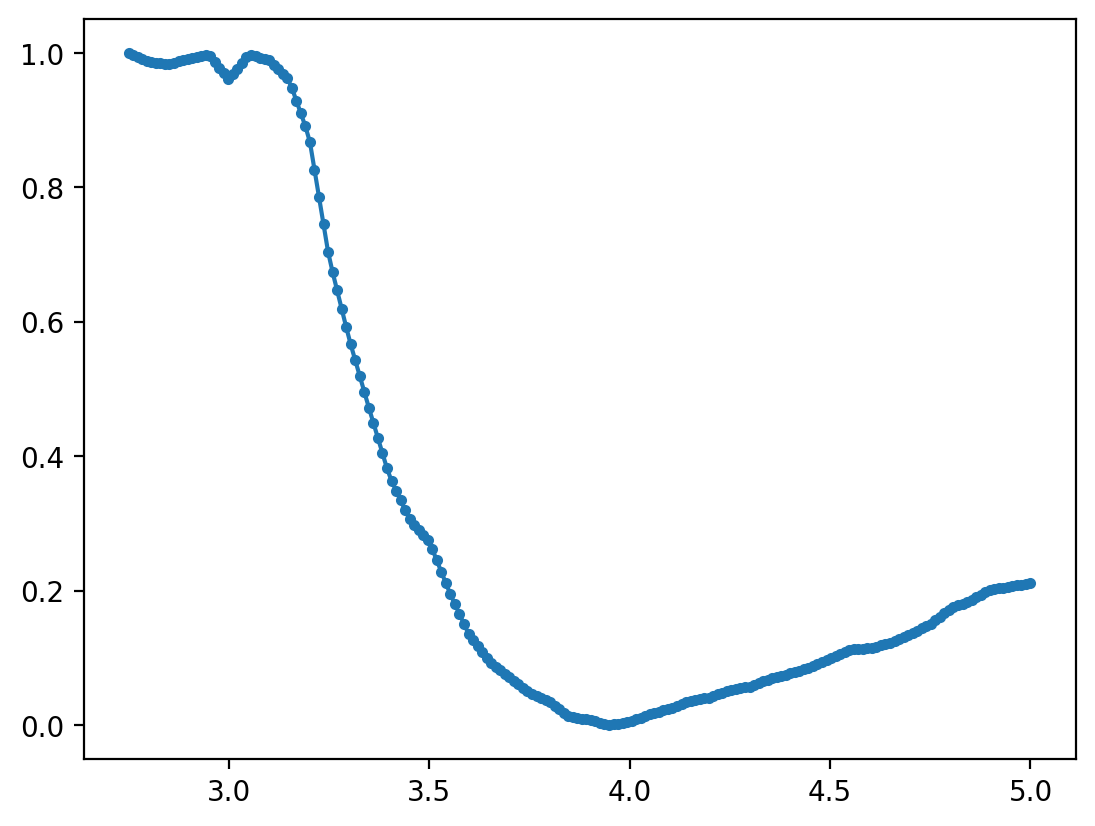

In [71]:
# Interpolate x and y with 200 points
stage_pos = df_crop['Stage'].to_numpy()
stage_interp = np.linspace(stage_pos.min(),stage_pos.max(),200)
y_data = np.flip(normalized_arr)
y_interp = np.interp(np.flip(stage_interp), stage_pos, y_data)
plt.plot(stage_interp, y_interp, '.-', label='Data')

In [72]:
# Find minima (at brewster's angle)
min_index = np.argmin(y_interp)
x_min = stage_interp[min_index]


print("Index of global minimum:", min_index)
print("X value at global minimum:", x_min)
print("Y value at global minimum:", y_interp[min_index])

# brewsters_angle = fresnel.brewster(1.515, n_i=1.00028460, deg=True)
brewsters_angle = fresnel.brewster(1.00028460, n_i=1.515, deg=True)

print("Brewster's angle for this interface (deg): ", brewsters_angle)
print("Critical angle for this interface (deg): ", fresnel.critical(n2, n_i=n1, deg=True))

Index of global minimum: 106
X value at global minimum: 3.948492462311558
Y value at global minimum: 0.00023074037844812346
Brewster's angle for this interface (deg):  33.434941781996834
Critical angle for this interface (deg):  41.471823767423416


Text(0.5, 1.0, 'EPI to Brewster')

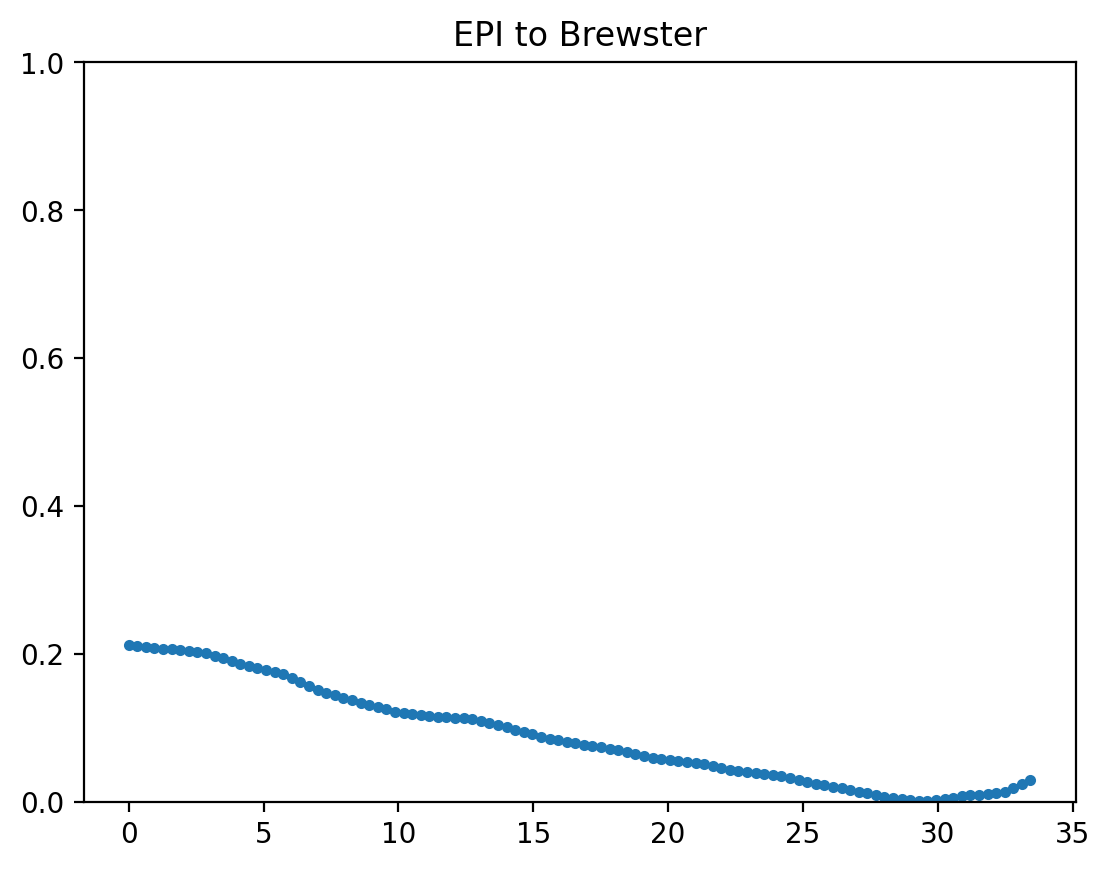

In [78]:
# EPI to brewster's angle
new_x_half,step_size = np.linspace(0.0,brewsters_angle,min_index, retstep=True)
plt.plot(new_x_half, np.flip(y_interp[94:200]), '.-', label='Data') # 94 is 200 - min_index
plt.ylim([0,1])
plt.title('EPI to Brewster')

In [93]:
# Construct the other half - from Brewster's angle to TIRF - something past 65 deg

ini_pt = brewsters_angle+step_size
end_pt = 68                             # Educated guess
new_x_other_half = np.arange(ini_pt, end_pt, step_size)

# Concatenate the two arrays

new_x = np.concatenate((new_x_half, new_x_other_half[0:len(y_interp)-min_index]))

Text(0.5, 1.0, 'Intensity vs angle')

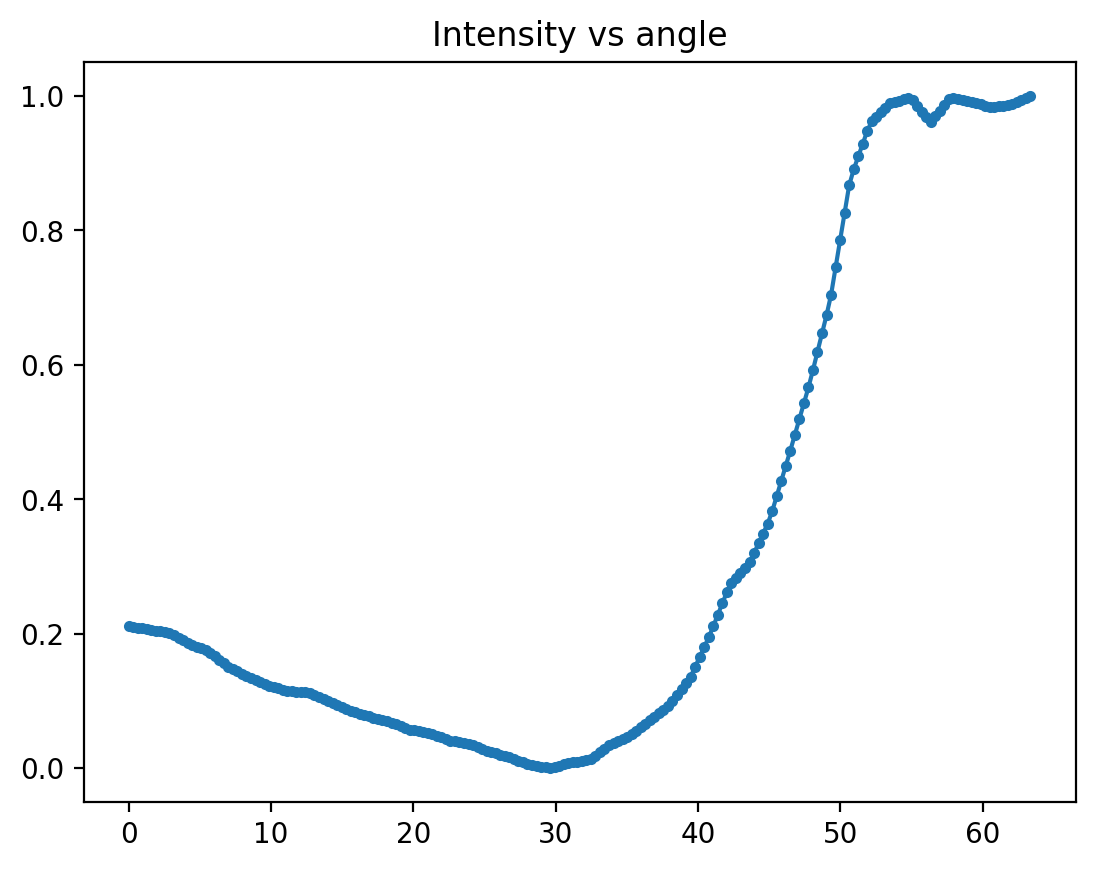

In [95]:
plt.plot(new_x, np.flip(y_interp), '.-', label='Data')
plt.title('Intensity vs angle')

In [106]:
def func(x, a,b):
    ang = x+b
    return a*fresnel.R_par(n2, ang, n_i=n1, deg=True)

popt, pcov = curve_fit(func, new_x[100:150], np.flip(y_interp)[100:150])
print(popt[1])

0.9541445951383628


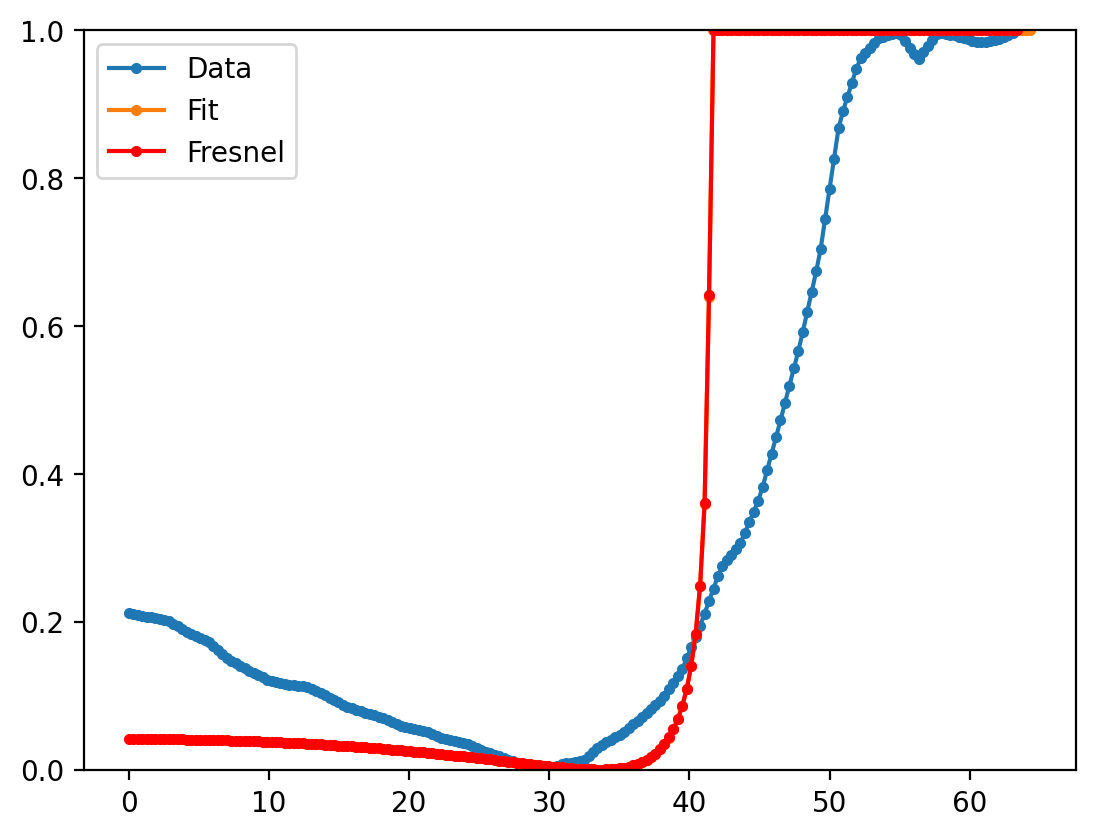

In [109]:
y_fresnel = fresnel.R_par(n2, new_x, n_i=n1, deg=True)

plt.plot(new_x, np.flip(y_interp), '.-', label='Data')
plt.plot(new_x+popt[1], func(new_x,*popt)/popt[0], '.-', label='Fit')
plt.plot(new_x, y_fresnel, 'r.-', label='Fresnel')
plt.ylim([0,1.0])
plt.legend()

Text(0.5, 1.0, 'Incident angle vs position')

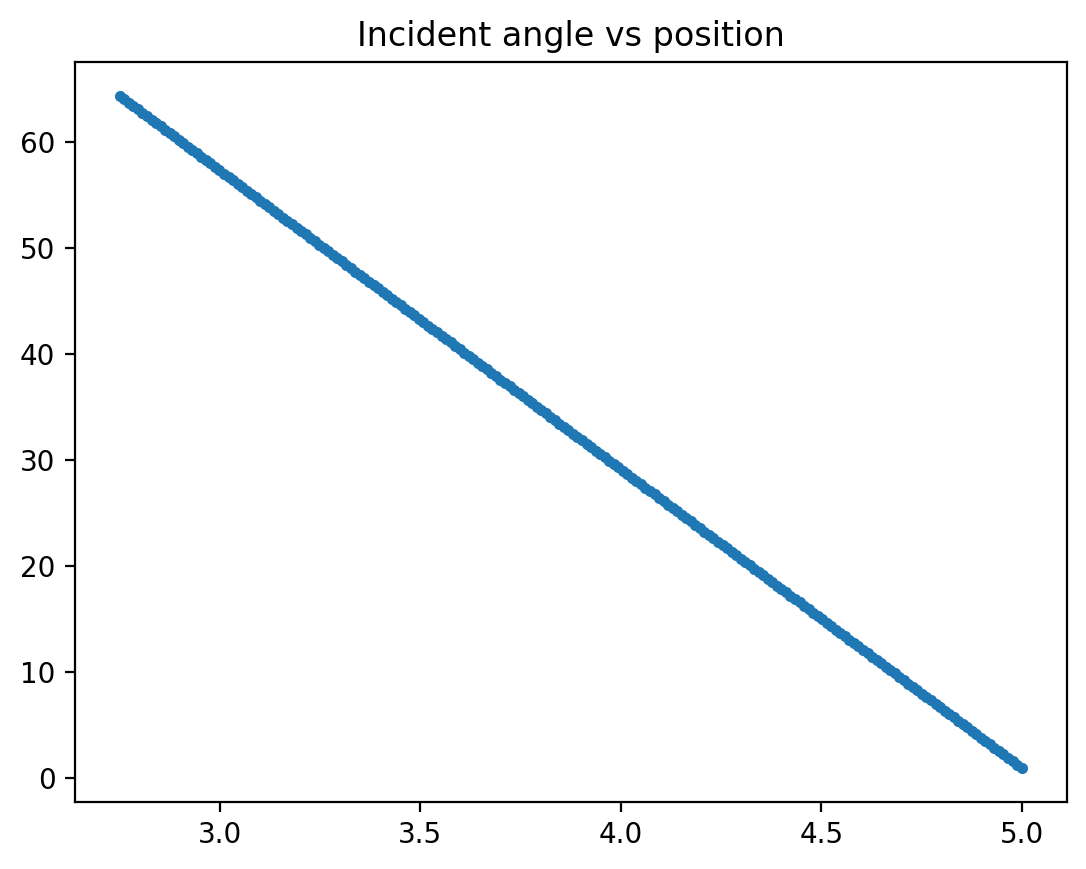

In [110]:
calibration_angles = new_x+popt[1]
stage_interp
plt.plot(stage_interp, np.flip(calibration_angles), '.-', label='Angles')
plt.title('Incident angle vs position')

In [111]:
data = np.column_stack((stage_interp, np.flip(calibration_angles), y_interp, y_fresnel))
df2 = pd.DataFrame({'Stage': data[:, 0], 'Angle': data[:, 1], 'Data': data[:, 2], 'Fresnel': data[:, 3]})
file_name = 'air-calibration-p-06-10-2025.csv'
df2.to_csv(file_name, index=False)